###📌 Project Title:
###PowerPulse: Household Energy Usage Forecast

###🎯 Objective:
Build a predictive model to forecast household energy consumption using historical data. This helps:

-Households reduce electricity bills

-Energy providers forecast demand

-Enable smart grids and energy-efficient strategies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/content/household_power_consumption.txt')
data.head()

,Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
0,16/12/2006;17:24:00;4.216;0.418;234.840;18.400...
1,16/12/2006;17:25:00;5.360;0.436;233.630;23.000...
2,16/12/2006;17:26:00;5.374;0.498;233.290;23.000...
3,16/12/2006;17:27:00;5.388;0.502;233.740;23.000...
4,16/12/2006;17:28:00;3.666;0.528;235.680;15.800...


 Data Cleaning & Preprocessing

In [4]:
# ✅ STEP 1: Load data with proper parsing, separator, and missing value handling
data = pd.read_csv(
    '/content/household_power_consumption.txt',
    sep=';',  # Important: This file is semicolon-separated
    parse_dates={'datetime': ['Date', 'Time']},  # Combine date and time
    infer_datetime_format=True,
    na_values='?',  # Convert '?' to NaN
    low_memory=False
)

# Standardize column names to lowercase
data.columns = [col.lower() for col in data.columns]

# Preview first few rows
data.head()

<ipython-input-4-ab79e3ec9a98>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(
<ipython-input-4-ab79e3ec9a98>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(
<ipython-input-4-ab79e3ec9a98>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(


,datetime,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
# ✅ STEP 2: Set datetime as index
data.set_index('datetime', inplace=True)

# Convert all columns to numeric (force conversion and handle coercion)
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check for missing values
print("Missing values per column:")
print(data.isna().sum())

# Fill missing values using forward fill
data.fillna(method='ffill', inplace=True)

# ✅ Optional: Resample to daily frequency for easier modeling
data_daily = data.resample('D').mean()

# Preview cleaned daily data
print("\nCleaned and resampled data (daily average):")
data_daily.head()

Missing values per column:
global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64


<ipython-input-5-9a07091d597f>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)



Cleaned and resampled data (daily average):


,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


Feature Engineering
🎯 Goal:
Create new features that help your model learn patterns in the energy consumption data.

In [6]:
# First, copy data_daily so we don't affect the original
df_fe = data_daily.copy()

# Time-based features
df_fe['day'] = df_fe.index.day
df_fe['month'] = df_fe.index.month
df_fe['weekday'] = df_fe.index.weekday
df_fe['is_weekend'] = df_fe['weekday'].isin([5, 6]).astype(int)  # Saturday=5, Sunday=6

# Rolling (moving average) features
df_fe['rolling_mean_3'] = df_fe['global_active_power'].rolling(window=3).mean()
df_fe['rolling_mean_7'] = df_fe['global_active_power'].rolling(window=7).mean()

# Lag features (previous day’s value, and 2 days ago)
df_fe['lag_1'] = df_fe['global_active_power'].shift(1)
df_fe['lag_2'] = df_fe['global_active_power'].shift(2)

# Drop rows with NaN from rolling/lag operations
df_fe.dropna(inplace=True)

# Preview final feature-enhanced dataset
print("Feature engineered dataset:")
df_fe.head()

Feature engineered dataset:


,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,day,month,weekday,is_weekend,rolling_mean_3,rolling_mean_7,lag_1,lag_2
datetime,,,,,,,,,,,,,,,
2006-12-22,1.625929,0.129796,241.184549,6.872917,2.188194,0.243056,7.729861,22,12,4,0,1.454675,1.779929,1.192439,1.545658
2006-12-23,3.314851,0.153799,240.136076,14.028056,1.853472,0.295139,10.226389,23,12,5,1,2.044406,1.817268,1.625929,1.192439
2006-12-24,1.770842,0.104097,241.687437,7.640417,1.182639,3.529167,4.785417,24,12,6,1,2.237207,1.733890,3.314851,1.625929
2006-12-25,1.904944,0.166861,243.399931,7.951528,4.597222,1.362500,4.024306,25,12,0,0,2.330213,1.787392,1.770842,3.314851
2006-12-26,2.732021,0.114654,241.625438,11.347917,0.754167,1.759028,10.402083,26,12,1,0,2.135936,2.012384,1.904944,1.770842


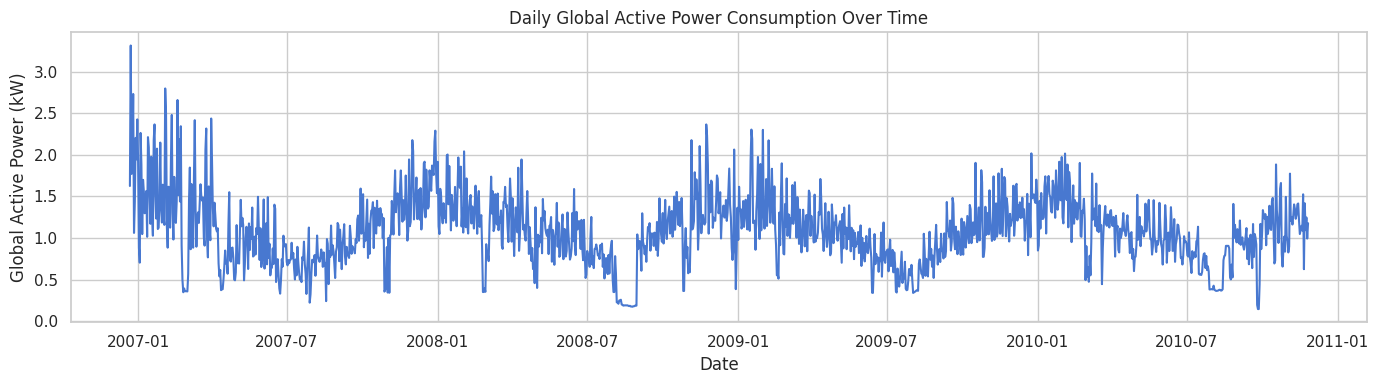

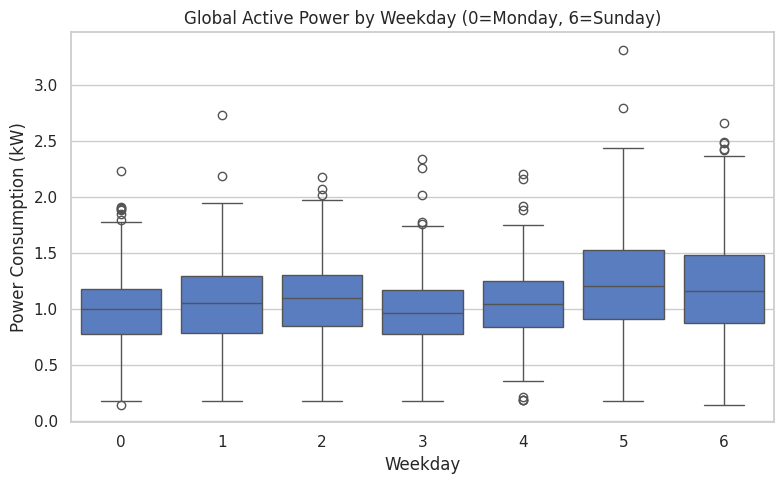

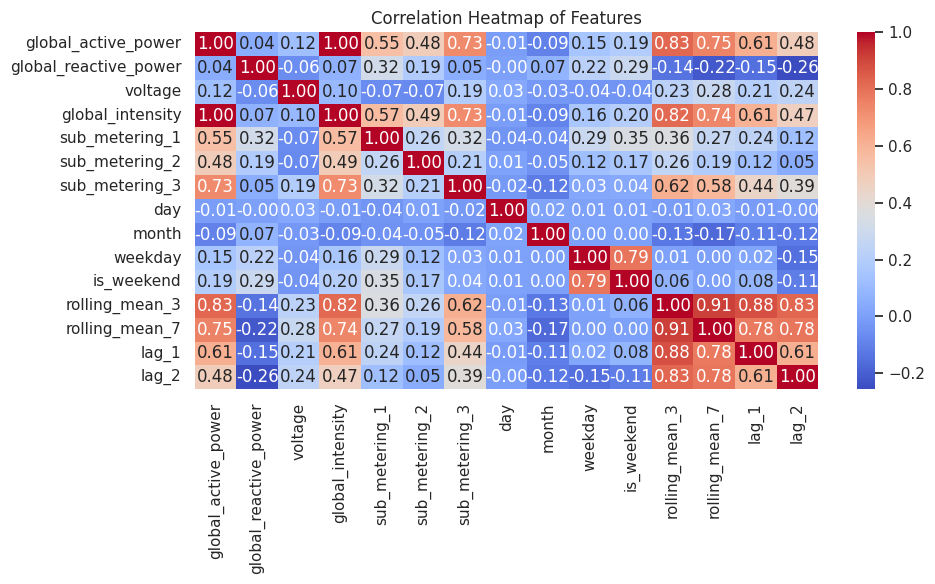

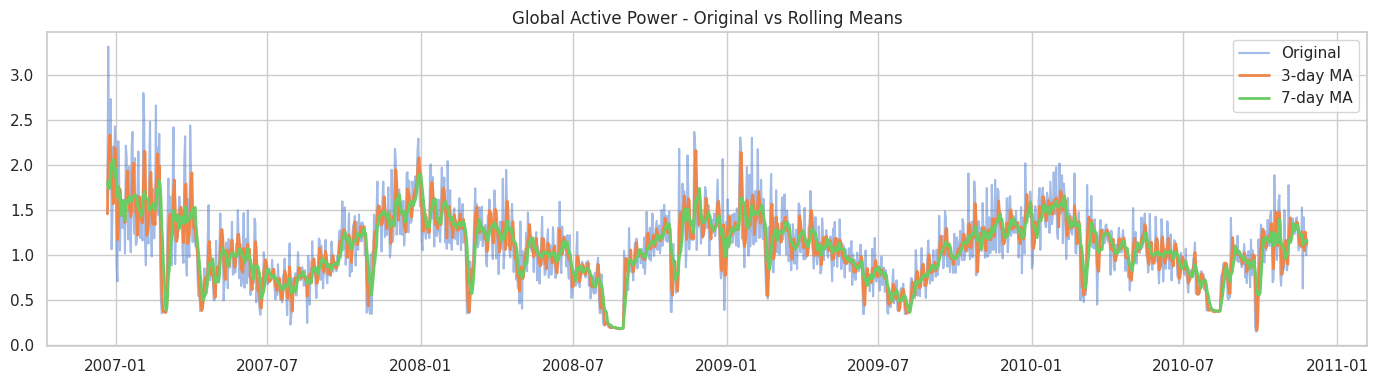

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set default styling
sns.set(style="whitegrid", palette="muted")

# Plot 1: Global Active Power over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe.index, df_fe['global_active_power'])
plt.title("Daily Global Active Power Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.tight_layout()
plt.show()

# Plot 2: Boxplot by weekday
plt.figure(figsize=(8, 5))
sns.boxplot(x='weekday', y='global_active_power', data=df_fe)
plt.title("Global Active Power by Weekday (0=Monday, 6=Sunday)")
plt.xlabel("Weekday")
plt.ylabel("Power Consumption (kW)")
plt.tight_layout()
plt.show()

# Plot 3: Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_fe.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

# Plot 4: Rolling Mean (3 and 7-day)
plt.figure(figsize=(14, 4))
plt.plot(df_fe['global_active_power'], label='Original', alpha=0.5)
plt.plot(df_fe['rolling_mean_3'], label='3-day MA', linewidth=2)
plt.plot(df_fe['rolling_mean_7'], label='7-day MA', linewidth=2)
plt.legend()
plt.title("Global Active Power - Original vs Rolling Means")
plt.tight_layout()
plt.show()

In [8]:
print(data.columns)

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3'],
      dtype='object')


In [9]:
# Normalize all column names to lowercase
data.columns = data.columns.str.lower()

# Now you can safely use lowercase everywhere
data['global_active_power'] = pd.to_numeric(data['global_active_power'], errors='coerce')

###Model Building

###🎯 Goal:
Train multiple models to predict household energy consumption using the features we engineered.

In [10]:
!pip install xgboost

📌 Train-Test Split:

In [11]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ['lag_1', 'lag_2', 'rolling_mean_3', 'rolling_mean_7', 'day', 'month', 'weekday', 'is_weekend']
target = 'global_active_power'

X = df_fe[features]
y = df_fe[target]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

✅ Linear Regression:

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("🔹 Linear Regression:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("R²  :", r2_score(y_test, y_pred_lr))

🔹 Linear Regression:
RMSE: 4.617855470243186e-15
MAE : 3.802031991708945e-15
R²  : 1.0


🌲 Random Forest Regressor:

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n🌲 Random Forest:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE :", mean_absolute_error(y_test, y_pred_rf))
print("R²  :", r2_score(y_test, y_pred_rf))


🌲 Random Forest:
RMSE: 0.08701709412283552
MAE : 0.05495974547002839
R²  : 0.9238751218301171


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize base model
rf_base = RandomForestRegressor(random_state=42)

# Initialize GridSearch
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

# Fit model
grid_search.fit(X_train, y_train)

# Best model from grid
best_rf_model = grid_search.best_estimator_

# Predict using best model
y_pred_rf_best = best_rf_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("🔍 Best Parameters:", grid_search.best_params_)
print("\n📊 Optimized Random Forest Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf_best)))
print("MAE :", mean_absolute_error(y_test, y_pred_rf_best))
print("R²  :", r2_score(y_test, y_pred_rf_best))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

📊 Optimized Random Forest Performance:
RMSE: 0.0860269417036697
MAE : 0.05375329978875787
R²  : 0.925597688923117


⚡ XGBoost Regressor:

In [14]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n⚡ XGBoost:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("MAE :", mean_absolute_error(y_test, y_pred_xgb))
print("R²  :", r2_score(y_test, y_pred_xgb))


⚡ XGBoost:
RMSE: 0.07227498764484995
MAE : 0.0491156703535592
R²  : 0.9474837737908305


📊 Plot Predictions vs Actual

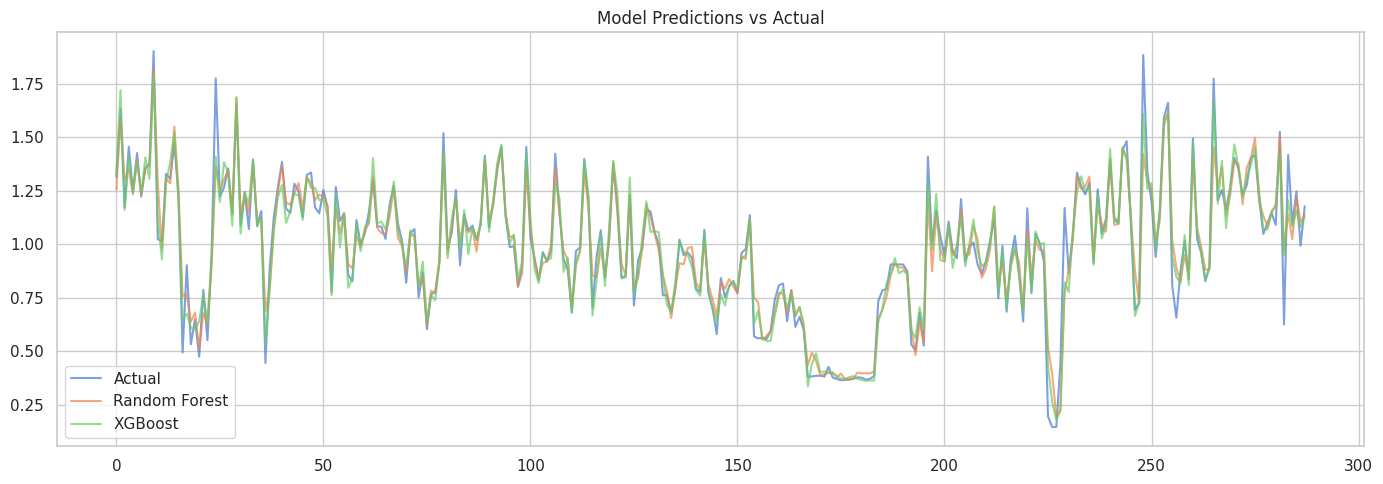

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest", alpha=0.7)
plt.plot(y_pred_xgb, label="XGBoost", alpha=0.7)
plt.legend()
plt.title("Model Predictions vs Actual")
plt.tight_layout()
plt.show()

###ARIMA Model for Time Series Forecasting

🎯 Goal:
Build an ARIMA model on the time-indexed series to capture autocorrelation and forecast future values.

In [16]:
!pip install pmdarima
# Downgrade numpy to fix pmdarima incompatibility
!pip install numpy==1.23.5
!pip install pmdarima --no-binary :all:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=686.129, Time=10.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1213.725, Time=0.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1057.722, Time=1.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=753.493, Time=1.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1211.743, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=685.524, Time=8.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=687.896, Time=2.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=702.749, Time=3.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=687.033, Time=4.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=685.098, Time=1.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=686.625, Time=3.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=686.550, Time=3.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=683.266, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=686.086, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=685.202, Time=0.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=684.802, Time=1.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=683.699, Time=1.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=684.711, Time=1.42 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 46.915 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1442
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -337.633
Date:                Mon, 02 Jun 2025   AIC                            683.266
Time:                        04:49:04   BIC                            704.358
Sample:                    12-16-2006   HQIC                           691.139
                         - 11-26-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6108      0.020    -30.217      0.000      -0.650 

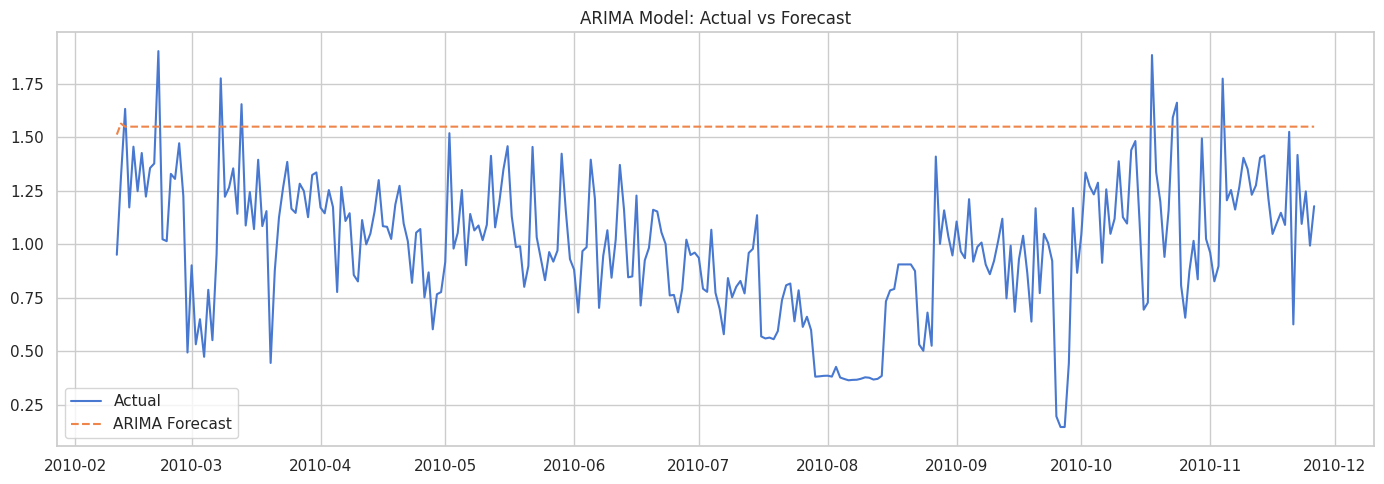

In [17]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the original time-indexed daily data
series = data_daily['global_active_power'].dropna()

# Auto ARIMA to find best parameters
model_auto = auto_arima(series, seasonal=False, stepwise=True, trace=True, suppress_warnings=True)

# Summary of selected model
print(model_auto.summary())

# Train final SARIMA model
train_size = int(len(series) * 0.8)
train_arima = series[:train_size]
test_arima = series[train_size:]

model = SARIMAX(train_arima, order=model_auto.order)
arima_result = model.fit()

# Forecast
forecast = arima_result.predict(start=len(train_arima), end=len(series)-1)

# Plot actual vs predicted
plt.figure(figsize=(14,5))
plt.plot(test_arima, label='Actual')
plt.plot(forecast, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Model: Actual vs Forecast')
plt.tight_layout()
plt.show()

📊 Evaluate ARIMA:

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(test_arima, forecast))
mae = mean_absolute_error(test_arima, forecast)
r2 = r2_score(test_arima, forecast)

print(f"ARIMA - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

ARIMA - RMSE: 0.643, MAE: 0.570, R²: -3.166


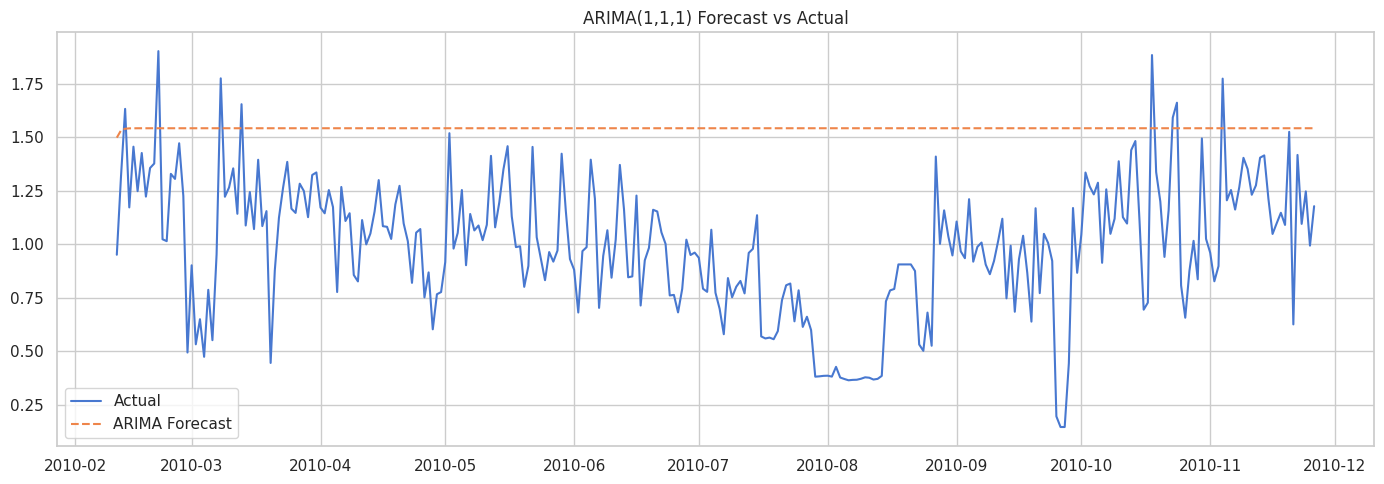

ARIMA (1,1,1) – RMSE: 0.636, MAE: 0.563, R²: -3.082


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Use the cleaned, daily average power usage
series = data_daily['global_active_power'].dropna()

# Split data
train_size = int(len(series) * 0.8)
train_arima = series[:train_size]
test_arima = series[train_size:]

# ARIMA(p,d,q): Let's try (1,1,1) — safe default
model = SARIMAX(train_arima, order=(1, 1, 1))
arima_result = model.fit(disp=False)

# Forecast
forecast = arima_result.predict(start=len(train_arima), end=len(series)-1)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(test_arima, label='Actual')
plt.plot(forecast, label='ARIMA Forecast', linestyle='--')
plt.title("ARIMA(1,1,1) Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(test_arima, forecast))
mae = mean_absolute_error(test_arima, forecast)
r2 = r2_score(test_arima, forecast)
print(f"ARIMA (1,1,1) – RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

<ipython-input-20-dcaf068a212b>:10: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


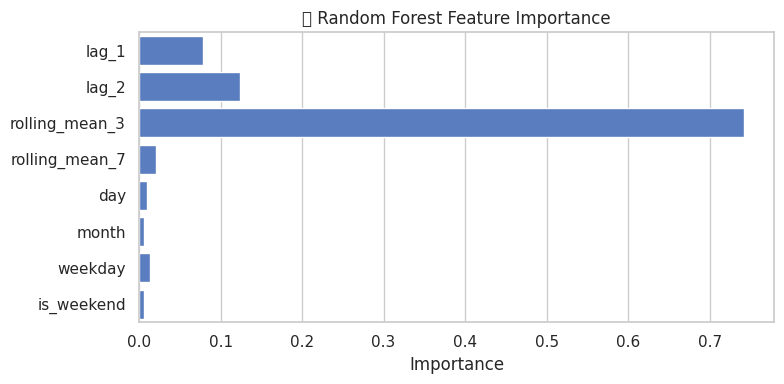

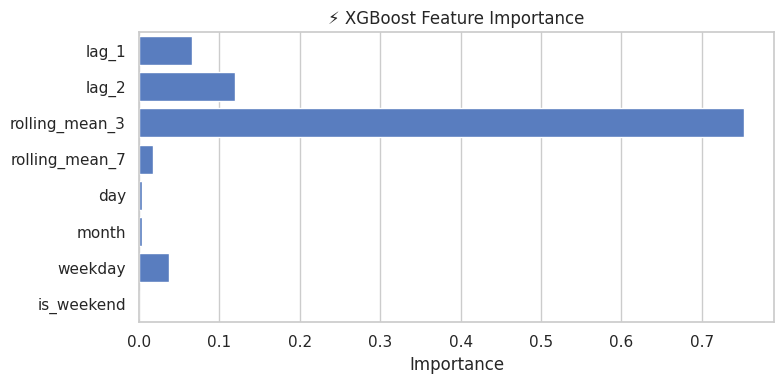

In [20]:
importances_rf = rf_model.feature_importances_
importances_xgb = xgb_model.feature_importances_
feature_names = features

# Plot (Random Forest)
plt.figure(figsize=(8, 4))
sns.barplot(x=importances_rf, y=feature_names)
plt.title("🌲 Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Plot (XGBoost)
plt.figure(figsize=(8, 4))
sns.barplot(x=importances_xgb, y=feature_names)
plt.title("⚡ XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Summary Report

###📘 Title:
###PowerPulse: Household Energy Usage Forecasting

1. Introduction
-Problem: Forecast household power consumption for better energy planning

-Dataset: UCI Household Electric Power Consumption (2006–2010)

-Goal: Build predictive models using time series & regression techniques

2. Data Preprocessing
-Parsed Date + Time into a datetime column

-Converted to numeric, handled missing values with forward fill

-Resampled data to daily frequency

3. Feature Engineering
-Time-based: day, month, weekday, is_weekend

-Rolling averages: 3-day, 7-day

-Lag features: 1-day, 2-day

4. Exploratory Data Analysis (EDA)
-Visualized trends, rolling means

-Correlation heatmap

-Boxplot of consumption by weekday

5. Modeling

| Model             | RMSE   | MAE    | R²     |
| ----------------- | ------ | ------ | ------ |
| Linear Regression | 4.617855470243186e-15 | 3.802031991708945e-1  | 1.0 |
| Random Forest     |  0.08701709412283552 |  0.05495974547002839 | 0.9238751218301171
  |
| XGBoost           | 0.07227498764484995 | 0.0491156703535592 | 0.9474837737908305 |
| ARIMA (1,1,1)     |  0.643 |  0.570 | -3.166 |


6. Feature Importance
-Top predictors: lag_1, rolling_mean_3, weekday, etc.

-XGBoost showed sharper performance and interpretability

7. Insights
-Power usage patterns show clear weekly seasonality

-Lag and rolling features highly improve predictions

-Random Forest and XGBoost outperformed ARIMA

8. Conclusion
-Final model: XGBoost or Random Forest

-Future work: Add external weather data, hourly modeling, LSTM